Kacie's Scripts

In [48]:
year = None
month = None
program = "prepilot"

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
from collections import defaultdict
import datetime

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

In [50]:
import scaffolding 
from plots import *

In [51]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r dic_ei
%store -r dic_re
%store -r dic_pur

# convert a dictionary to a defaultdict
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_re = defaultdict(lambda: 'Other',dic_re)

no stored variable or alias dic_ei


In [52]:
tq = scaffolding.get_time_query(year, month)

In [53]:
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('bd9cffc8-dbf1-402d-a479-f9f148ec9e60'),
 UUID('fc8f71a3-8c82-458d-bf97-18c3ee11a0f3'),
 UUID('f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0'),
 UUID('8b1f3ba4-3de9-45be-a79d-e6a81716ad04'),
 UUID('9606d610-4d24-4960-a77d-9211c5b587ec'),
 UUID('15eb78dd-6e10-4966-ba61-12589c29dc41'),
 UUID('e5015494-1416-43f9-a2e6-fb845e1e9183'),
 UUID('15aa4ba1-44a3-4b8b-8079-ed7e049d84df'),
 UUID('b36f7b55-65a3-40d8-aa97-0590bfb14782'),
 UUID('7abe5721-4886-4412-a339-79592fa985fb'),
 UUID('8fdc9b92-6a67-4a9e-a07d-91df2c5e06f2'),
 UUID('fbff5e08-b7f2-4a94-ab4b-2d7371999ef7'),
 UUID('a7e9b775-6b3a-439d-b110-0472e5954230'),
 UUID('742fbefa-e7d7-45a9-bdf6-44659d21e0fa'),
 UUID('f0db3b19-99c2-410b-a593-3103eca9212f'),
 UUID('37bc8629-38aa-470a-bd9d-2aaf3c2ac680'),
 UUID('8c3c63ab-b3ec-4fc3-a61e-7bf316ee4efd'),
 UUID('367eb90b-929d-4f6e-9470-d15c700d2e3f'),
 UUID('b4500762-e0f0-432b-9d1a-35a028715f18'),
 UUID('858936a7-bf62-466b-8bee-af3ae6161cb9'),
 UUID('b1aed24c-8639-49bf-bfa3-a844ecf60593'),
 UUID('ea557d

Loaded all confirmed trips of length 135471


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,start_place,end_place,cleaned_trip,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,user_input,start_local_dt_year,start_local_dt_month,start_local_dt_day,start_local_dt_hour,start_local_dt_minute,start_local_dt_second,start_local_dt_weekday,start_local_dt_timezone,end_local_dt_year,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,61490c97298be5cdcb8ed75f,61490c97298be5cdcb8ed760,61490c97298be5cdcb8ed73d,[],61490ca0298be5cdcb8ed765,{'to_label': True},0.25,61490ca0298be5cdcb8ed769,"{'mode_confirm': 'drove_alone', 'purpose_confi...",2021,9,20,16,0,8,0,America/Denver,2021,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,61490c97298be5cdcb8ed760,61491aa8b9593ff96f7257f8,61491aa7b9593ff96f7257d8,[],61491aafb9593ff96f725800,{'to_label': True},0.25,61491aafb9593ff96f725807,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,30,32,0,America/Denver,2021,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,61491aa8b9593ff96f7257f8,61491aa8b9593ff96f7257f9,61491aa8b9593ff96f7257df,[],61491aafb9593ff96f725803,{'to_label': True},0.25,61491aafb9593ff96f725808,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,56,13,0,America/Denver,2021,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,61491aa8b9593ff96f7257f9,614928b7dd5719f85e04c59d,614928b7dd5719f85e04c57d,[],614928c0dd5719f85e04c5a2,{'to_label': True},0.25,614928c0dd5719f85e04c5a6,"{'mode_confirm': 'drove_alone', 'replaced_mode...",2021,9,20,17,19,25,0,America/Denver,2021,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,6149df8862cecc2c7249b651,6149df8862cecc2c7249b652,6149df8862cecc2c7249b62b,[],6149df8862cecc2c7249b657,{'to_label': True},0.25,6149df8862cecc2c7249b65b,"{'mode_confirm': 'shared_ride', 'purpose_confi...",2021,9,21,6,59,10,1,America/Denver,2021,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09


After filtering, found 135471 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,start_place,end_place,cleaned_trip,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,user_input,start_local_dt_year,start_local_dt_month,start_local_dt_day,start_local_dt_hour,start_local_dt_minute,start_local_dt_second,start_local_dt_weekday,start_local_dt_timezone,end_local_dt_year,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,61490c97298be5cdcb8ed75f,61490c97298be5cdcb8ed760,61490c97298be5cdcb8ed73d,[],61490ca0298be5cdcb8ed765,{'to_label': True},0.25,61490ca0298be5cdcb8ed769,"{'mode_confirm': 'drove_alone', 'purpose_confi...",2021,9,20,16,0,8,0,America/Denver,2021,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,61490c97298be5cdcb8ed760,61491aa8b9593ff96f7257f8,61491aa7b9593ff96f7257d8,[],61491aafb9593ff96f725800,{'to_label': True},0.25,61491aafb9593ff96f725807,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,30,32,0,America/Denver,2021,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,61491aa8b9593ff96f7257f8,61491aa8b9593ff96f7257f9,61491aa8b9593ff96f7257df,[],61491aafb9593ff96f725803,{'to_label': True},0.25,61491aafb9593ff96f725808,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,56,13,0,America/Denver,2021,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,61491aa8b9593ff96f7257f9,614928b7dd5719f85e04c59d,614928b7dd5719f85e04c57d,[],614928c0dd5719f85e04c5a2,{'to_label': True},0.25,614928c0dd5719f85e04c5a6,"{'mode_confirm': 'drove_alone', 'replaced_mode...",2021,9,20,17,19,25,0,America/Denver,2021,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,6149df8862cecc2c7249b651,6149df8862cecc2c7249b652,6149df8862cecc2c7249b62b,[],6149df8862cecc2c7249b657,{'to_label': True},0.25,6149df8862cecc2c7249b65b,"{'mode_confirm': 'shared_ride', 'purpose_confi...",2021,9,21,6,59,10,1,America/Denver,2021,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09


In [54]:
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)

After filtering, found 57729 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,start_place,end_place,cleaned_trip,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,user_input,start_local_dt_year,start_local_dt_month,start_local_dt_day,start_local_dt_hour,start_local_dt_minute,start_local_dt_second,start_local_dt_weekday,start_local_dt_timezone,end_local_dt_year,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,61490c97298be5cdcb8ed75f,61490c97298be5cdcb8ed760,61490c97298be5cdcb8ed73d,[],61490ca0298be5cdcb8ed765,{'to_label': True},0.25,61490ca0298be5cdcb8ed769,"{'mode_confirm': 'drove_alone', 'purpose_confi...",2021,9,20,16,0,8,0,America/Denver,2021,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,61490c97298be5cdcb8ed760,61491aa8b9593ff96f7257f8,61491aa7b9593ff96f7257d8,[],61491aafb9593ff96f725800,{'to_label': True},0.25,61491aafb9593ff96f725807,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,30,32,0,America/Denver,2021,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,61491aa8b9593ff96f7257f8,61491aa8b9593ff96f7257f9,61491aa8b9593ff96f7257df,[],61491aafb9593ff96f725803,{'to_label': True},0.25,61491aafb9593ff96f725808,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,56,13,0,America/Denver,2021,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,61491aa8b9593ff96f7257f9,614928b7dd5719f85e04c59d,614928b7dd5719f85e04c57d,[],614928c0dd5719f85e04c5a2,{'to_label': True},0.25,614928c0dd5719f85e04c5a6,"{'mode_confirm': 'drove_alone', 'replaced_mode...",2021,9,20,17,19,25,0,America/Denver,2021,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,6149df8862cecc2c7249b651,6149df8862cecc2c7249b652,6149df8862cecc2c7249b62b,[],6149df8862cecc2c7249b657,{'to_label': True},0.25,6149df8862cecc2c7249b65b,"{'mode_confirm': 'shared_ride', 'purpose_confi...",2021,9,21,6,59,10,1,America/Denver,2021,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09


In [55]:
expanded_ct = scaffolding.expand_userinputs(labeled_ct)

,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,personal_med,no_travel
1,drove_alone,shopping,drove_alone
2,drove_alone,shopping,drove_alone
3,drove_alone,shopping,drove_alone
4,shared_ride,work,bike


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,start_place,end_place,cleaned_trip,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,user_input,start_local_dt_year,start_local_dt_month,start_local_dt_day,start_local_dt_hour,start_local_dt_minute,start_local_dt_second,start_local_dt_weekday,start_local_dt_timezone,end_local_dt_year,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,61490c97298be5cdcb8ed75f,61490c97298be5cdcb8ed760,61490c97298be5cdcb8ed73d,[],61490ca0298be5cdcb8ed765,{'to_label': True},0.25,61490ca0298be5cdcb8ed769,"{'mode_confirm': 'drove_alone', 'purpose_confi...",2021,9,20,16,0,8,0,America/Denver,2021,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09,drove_alone,personal_med,no_travel
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,61490c97298be5cdcb8ed760,61491aa8b9593ff96f7257f8,61491aa7b9593ff96f7257d8,[],61491aafb9593ff96f725800,{'to_label': True},0.25,61491aafb9593ff96f725807,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,30,32,0,America/Denver,2021,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09,drove_alone,shopping,drove_alone
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,61491aa8b9593ff96f7257f8,61491aa8b9593ff96f7257f9,61491aa8b9593ff96f7257df,[],61491aafb9593ff96f725803,{'to_label': True},0.25,61491aafb9593ff96f725808,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,56,13,0,America/Denver,2021,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09,drove_alone,shopping,drove_alone
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,61491aa8b9593ff96f7257f9,614928b7dd5719f85e04c59d,614928b7dd5719f85e04c57d,[],614928c0dd5719f85e04c5a2,{'to_label': True},0.25,614928c0dd5719f85e04c5a6,"{'mode_confirm': 'drove_alone', 'replaced_mode...",2021,9,20,17,19,25,0,America/Denver,2021,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09,drove_alone,shopping,drove_alone
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,6149df8862cecc2c7249b651,6149df8862cecc2c7249b652,6149df8862cecc2c7249b62b,[],6149df8862cecc2c7249b657,{'to_label': True},0.25,6149df8862cecc2c7249b65b,"{'mode_confirm': 'shared_ride', 'purpose_confi...",2021,9,21,6,59,10,1,America/Denver,2021,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09,shared_ride,work,bike


In [56]:
expanded_ct.shape

(57729, 41)

In [57]:
expanded_ct = scaffolding.data_quality_check(expanded_ct)
expanded_ct.shape

(57729, 41)

In [58]:
## Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

In [64]:
dic_pur

defaultdict(<function __main__.<lambda>()>,
            {'work_travel': 'Work',
             'work': 'Work',
             'home': 'Home',
             'meal': 'Meal',
             'shopping': 'Shopping',
             'personal_med': 'Personal/Medical',
             'exercise': 'Recreation/Exercise',
             'transit_transfer': 'Transit transfer',
             'pick_drop': 'Pick-up/Drop off',
             'entertainment': 'Entertainment/Social',
             'car_mechanic': 'Other',
             'school': 'School',
             'revisado_bike': 'Other',
             'placas_de carro': 'Other',
             'community_walk': 'Entertainment/Social',
             'gardening': 'Entertainment/Social',
             'visiting': 'Entertainment/Social',
             'church': 'Religious',
             'community_garden': 'Entertainment/Social',
             'community_meeting': 'Entertainment/Social',
             'visit_a friend': 'Entertainment/Social',
             'aseguranza': 'Other',

In [65]:
assert len(expanded_ct[(expanded_ct['Mode_confirm'] == 'Pilot ebike') & (expanded_ct["Replaced_mode"] == "Pilot ebike")]) == 0

In [66]:
# Energy Impact Calculation
scaffolding.unit_conversions(expanded_ct)

In [67]:
file_suffix = scaffolding.get_file_suffix(year, month, program)

_prepilot


In [68]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_prepilot
Based on 57729 confirmed trips from 200 users
of 135471 total trips from 219 users (42.61%)


Demographics

In [ ]:
#All Project Participants - includes stage users and participant users
#Participant users - excludes stage users

In [69]:
#All the demographic survey entries
demog = pd.read_csv("Can Do Colorado eBike Program - en.csv")
#demog.columns
demog.columns = ['Timestamp','user_id','YearOfBirth','Gender','DriversLicense','Student','HighestDegree','Work','MoreThanOneJob','FullPartTime','Job','TranspToJobLastWeek','DailyCommuteMinsToJob','ChangeStartTime','CanWFH','DaysPerWeekWFT','DescribesYouBest','OwnRentResidence','HomeType','Income','PplInHome','ChildrenUnder18','NumOfDrivers','NumVehicles','AltTranspt','MedCond','HowLongMedCond']
demog

es_users = pd.read_csv("Can Do Colorado eBike Program - es.csv")

# this translates the spanish df to the english df

es_users.columns = demog.columns # translate cols to english
pd.set_option('display.max_columns', None)
# the rest of this is a little clunky, but it's good for the plots I make (so far)
es_users = es_users.replace("Menos de $24,999", "Less than $24,999")
es_users = es_users.replace("Femenino.", "Woman")
es_users = es_users.replace("Masculino.", "Man")
es_users = es_users.replace("Si", "Yes")
es_users = es_users.replace("Bicicleta", "Bicycle")
es_users = es_users.replace("Teletrabajo", "Telecommute")
es_users = es_users.replace("Caminar", "Walk")
es_users = es_users.replace("Graduado de secundaria o GED.", "High school graduate or GED")
en_es_users = demog.append(es_users) #df of both english and spanish
en_es_users

,Timestamp,user_id,YearOfBirth,Gender,DriversLicense,Student,HighestDegree,Work,MoreThanOneJob,FullPartTime,Job,TranspToJobLastWeek,DailyCommuteMinsToJob,ChangeStartTime,CanWFH,DaysPerWeekWFT,DescribesYouBest,OwnRentResidence,HomeType,Income,PplInHome,ChildrenUnder18,NumOfDrivers,NumVehicles,AltTranspt,MedCond,HowLongMedCond
0,2021/05/23 4:21:52 PM MDT,a2d48b05d5454d428c0841432c7467b6,1974,Woman,Yes,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Telecommute,2.00,Yes,Yes,5.0,NaN,Own,Single family house,"$150,000",4,2,2,1,"Public transportation (bus, subway, light rail...",No,NaN
1,2021/05/26 1:13:49 PM MDT,f2799dc202bc4249b42a4fda8770d1b6,1984,Woman,Yes,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Car,20.00,Yes,Yes,5.0,NaN,Own,Single family house,"$25,000-$49,999",3,1,2,1,Bicycle,No,NaN
2,2021/05/28 1:48:02 PM MDT,b2bbe715b6a14fd19f751cae8adf6b4e,1981,Man,Yes,Not a student,Some college or associates degree,Yes,No,Full-time,"Professional, managerial, or technical",Telecommute,0.00,Yes,Yes,5.0,NaN,Own,Prefer not to say,Prefer not to say,4,2,2,2,"Public transportation (bus, subway, light rail...",No,NaN
3,2021/05/30 6:53:16 AM MDT,6373dfb8cb9b47e88e8f76adcfadde20,1978,Woman,Prefer not to say,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Bicycle,20.00,Yes,Yes,5.0,NaN,Own,Single family house,"$50,000-$99,999",1,0,1,0,Bicycle,No,NaN
4,2021/06/04 2:43:41 PM MDT,93c6e0f156a44e07b920ded664419dc6,1986,Woman,Yes,Not a student,Bachelor's degree,Yes,Yes,Part-time,Sales or service,Bicycle,15.00,Yes,Yes,1.0,NaN,Rent,Condominium/apartment,"$25,000-$49,999",2,0,2,1,Bicycle;Walk/roll,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2021/10/07 11:33:12 PM MDT,0236fb3de4ab448eab777256d4536609,1966,Man,Yes,No es un estudiante.,Licenciatura o título profesional.,No,No,Tiempo completo,"Profesional, gerencial o técnico.",Bicycle,0.00,Yes,Yes,5.0,Actualmente estoy empleado trabajando desde casa.,Propio.,Casa unifamiliar.,"$50,000-$99,999",4,2,2,2,Bicycleta.,No,NaN
4,2021/10/08 3:30:39 AM MDT,b8f2413f2c904bbb95e8011129df5fc2,1988,Man,Yes,No es un estudiante.,Algún título universitario o asociado.,Yes,No,Tiempo completo,"Profesional, gerencial o técnico.",Telecommute,40.00,No,Yes,4.0,NaN,Propio.,Condominio / apartamento.,"$50,000-$99,999",1,0,1,1,Obtener transporte de un amigo o familiar.;Bic...,No,NaN
5,2021/11/19 11:08:37 AM MST,0236fb3de4ab448eab777256d4536609,1966,Man,Yes,No es un estudiante.,Licenciatura.,No,No,Tiempo completo,"Profesional, gerencial o técnico.",Walk,10.00,Yes,Yes,5.0,Actualmente estoy empleado trabajando desde casa.,Propio.,Casa unifamiliar.,"$50,000-$99,999",4,2,2,2,"Transporte público (autobús, metro, tren liger...",No,NaN
6,2021/12/01 8:25:40 AM MST,0236fb3de4ab448eab777256d4536609,1966,Man,Yes,No es un estudiante.,Algún título universitario o asociado.,Yes,No,Tiempo completo,"Profesional, gerencial o técnico.",Bicycle,3.00,Yes,Yes,5.0,NaN,Propio.,Casa unifamiliar.,"$50,000-$99,999",5,2,2,2,"Transporte público (autobús, metro, tren liger...",No,NaN


In [70]:
#df of all project partcipants, including only the last survey entry, no duplicates
#First survey entry 5-23-2021
#Last survey entry on 5-10-2022
pd.set_option('display.max_rows', 10)
demog = en_es_users
demog1 = demog.sort_values(by = 'Timestamp')
demogRecent = demog1.drop_duplicates(subset='user_id',keep = 'last')
demogRecent=demogRecent.reset_index()
demogRecent

,index,Timestamp,user_id,YearOfBirth,Gender,DriversLicense,Student,HighestDegree,Work,MoreThanOneJob,FullPartTime,Job,TranspToJobLastWeek,DailyCommuteMinsToJob,ChangeStartTime,CanWFH,DaysPerWeekWFT,DescribesYouBest,OwnRentResidence,HomeType,Income,PplInHome,ChildrenUnder18,NumOfDrivers,NumVehicles,AltTranspt,MedCond,HowLongMedCond
0,0,2021/05/23 4:21:52 PM MDT,a2d48b05d5454d428c0841432c7467b6,1974,Woman,Yes,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Telecommute,2.0,Yes,Yes,5.0,NaN,Own,Single family house,"$150,000",4,2,2,1,"Public transportation (bus, subway, light rail...",No,NaN
1,2,2021/05/28 1:48:02 PM MDT,b2bbe715b6a14fd19f751cae8adf6b4e,1981,Man,Yes,Not a student,Some college or associates degree,Yes,No,Full-time,"Professional, managerial, or technical",Telecommute,0.0,Yes,Yes,5.0,NaN,Own,Prefer not to say,Prefer not to say,4,2,2,2,"Public transportation (bus, subway, light rail...",No,NaN
2,3,2021/05/30 6:53:16 AM MDT,6373dfb8cb9b47e88e8f76adcfadde20,1978,Woman,Prefer not to say,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Bicycle,20.0,Yes,Yes,5.0,NaN,Own,Single family house,"$50,000-$99,999",1,0,1,0,Bicycle,No,NaN
3,9,2021/06/10 5:55:32 PM MDT,71f21d53b655463784f3a3c63c56707b,2000,Man,Yes,Yes - Full Time College/University,Some college or associates degree,Yes,Yes,Full-time,"Professional, managerial, or technical",Telecommute,0.0,Yes,Yes,5.0,NaN,Prefer not to say,Prefer not to say,Prefer not to say,5,2,4,2,"Public transportation (bus, subway, light rail...",No,NaN
4,8,2021/06/10 8:46:10 AM MDT,405b221abe9e43bc86a57ca7fccf2227,1970,Man,Yes,Not a student,Graduate degree or professional degree,Yes,No,Full-time,"Professional, managerial, or technical",Pickup truck,5.0,Yes,Yes,5.0,NaN,Rent,Condominium/apartment,"$50,000-$99,999",1,0,2,2,Get a ride from a friend or family member;Walk...,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,289,2022/04/08 10:44:06 AM MDT,c9a686318e1448cc81c715fd7e0a5811,1983,Woman,Yes,Not a student,Some college or associates degree,Yes,Yes,Full-time,Clerical or administrative support,Car,15.0,No,No,NaN,NaN,Own,Single family house,"Less than $24,999",2,1,1,0,Get a ride from a friend or family member;Bicycle,No,NaN
196,290,2022/04/08 10:44:50 AM MDT,2049efd4211e461f85b3b64b55c7b5b9,1968,Woman,Yes,Not a student,Some college or associates degree,Yes,No,Full-time,Preschool Tracher,Car,15.0,No,No,NaN,NaN,Own,Single family house,"$50,000-$99,999",4,0,4,4+,Get a ride from a friend or family member,No,NaN
197,292,2022/05/01 1:06:41 AM MDT,863e9c6c8ec048c4b7653f73d839c85b,1971,Man,Yes,Not a student,Some college or associates degree,Yes,No,Full-time,Sales or service,Bicycle,15.0,No,No,NaN,NaN,Rent,Single family house,Prefer not to say,2,0,2,2,Get a ride from a friend or family member;Bicy...,No,NaN
198,293,2022/05/03 10:06:40 AM MDT,39db1e03b46c43129aa8dbe3bbe16687,1990,Man,No,Not a student,High school graduate or GED,Yes,Yes,Full-time,Sales or service,Public or commuter bus,10.0,No,No,NaN,NaN,Rent,Condominium/apartment,"Less than $24,999",1,0,0,0,"Public transportation (bus, subway, light rail...",No,NaN


In [71]:
#Dataframe that includes all survey entries that are more than 2 weeks apart
demogSep = demog.drop([247,123,254,262,30,256,33,55,70,114,239,251,237,238,206,21,219,23,94,95,121,106,91,63,59,280,283,13,182,56,233,90,60,103,153,176,145,135,27,101,132,217,5,6,1,29])
#demogSep.user_id.value_counts()

In [72]:
#Less than $24,999
#$25,000-$49,999
#$50,000-$99,999
#$100,000 -$149,999
#$150,000-$199,999
#$200,000 or more
#Prefer not to say
def returnIncomeDistribution(demog,title):
    lessThan24=0
    i25to49=0
    i50to99=0
    i100to149=0
    i150to199=0
    i200orMore=0
    NA=0
    
    for i in range(len(demog)):
        if str(demog.Income.iloc[i]).__contains__('24,999'):
            lessThan24+=1
        elif str(demog.Income.iloc[i]).__contains__('25,000'):
            i25to49+=1
        elif str(demog.Income.iloc[i]).__contains__('100,000'):
            i100to149+=1
        elif str(demog.Income.iloc[i]).__contains__('150,000'):
            i150to199+=1
        elif str(demog.Income.iloc[i]).__contains__('50,000'):
            i50to99+=1
        elif str(demog.Income.iloc[i]).__contains__('200,000'):
            i200orMore+=1
        elif str(demog.Income.iloc[i]).__contains__('Prefer'):
            NA+=1    

    values = [lessThan24,i25to49,i50to99,i100to149,i150to199,i200orMore,NA]
    income = ['Less than $24,999','\$25,000-\$49,999','\$50,000-\$99,999','\$100,000-\$149,999','\$150,000-\$199,999','$200,000 or more','Prefer not to say']
    colours = dict(zip(values, plt.cm.tab20.colors[:len(values)]))
    def func(pct, values):
            total = sum(values)
            absolute = int(round(pct*total/100.0))
            return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 3 else''
    fig = plt.figure(figsize =(10, 10))
    plt.pie(values, labels = income, colors=[colours[key] for key in values], pctdistance=.75, autopct=lambda pct: func(pct, values),textprops={'size': 16})
    plt.title(title, fontsize=25)
    plt.show()

In [73]:
def AgeDistribution(demog,title):
    demog['Age']=0
    for i in range(len(demog)):
        #print('hi',i)
        if int(demog.iloc[i].YearOfBirth) > 22 and int(demog.iloc[i].YearOfBirth) < 1000:
            demog.at[i,'Age']=2022-(int(demog.iloc[i].YearOfBirth)+1900)
        else:
            #print('false')
            demog.at[i,'Age']=2022-int(demog.YearOfBirth.iloc[i])
    age = [demog.Age]
    plt.hist(age, bins = len(demog.Age.unique()))
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Number of Participants')
    plt.show()

In [74]:
#def AgeDistribution(demog):
#    demog=demog.assign(Age=2022-demogRecent.YearOfBirth)
#    demog1=demog.reset_index()
#    for i in range(len(demog1)):
#        if demog1.loc[i].YearOfBirth > 22 and demog1.loc[i].YearOfBirth < 1000:
#            demog1.at[i,'Age']=2022-(demog1.loc[i].YearOfBirth+1900)
#    age = [demog1.Age]
#    plt.hist(age, bins = 13)
#    plt.title('Age Distribution of Participants')
#    plt.xlabel('Age')
#    plt.ylabel('Number of Participants')
#    plt.show()

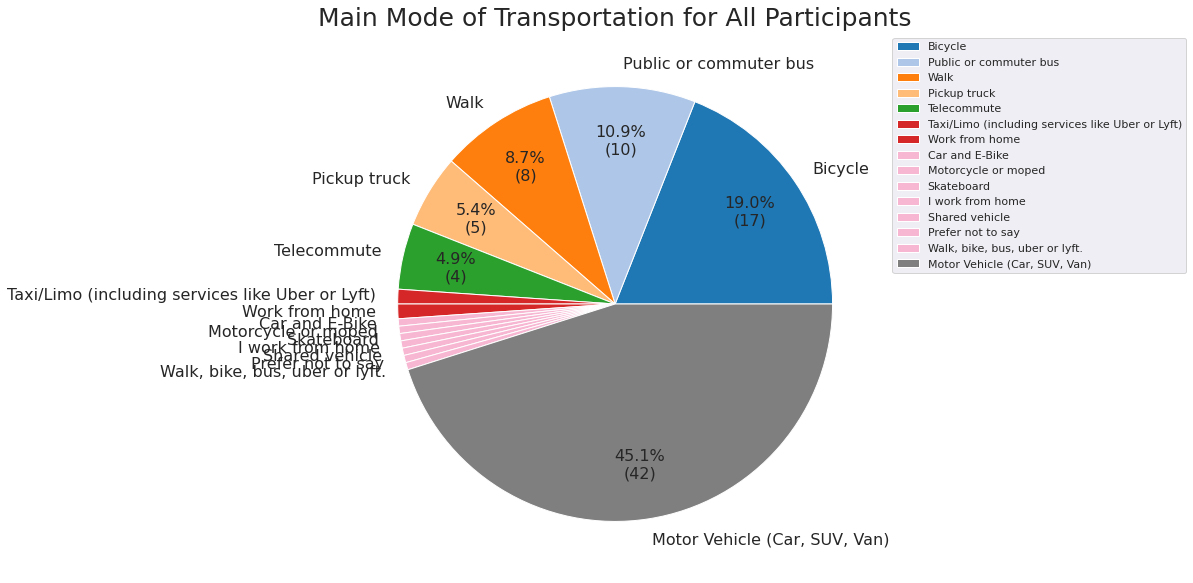

Index(['Bicycle', 'Public or commuter bus', 'Walk', 'Pickup truck',
       'Telecommute', 'Taxi/Limo (including services like Uber or Lyft)',
       'Work from home', 'Car and E-Bike', 'Motorcycle or moped', 'Skateboard',
       'I work from home', 'Shared vehicle', 'Prefer not to say',
       'Walk, bike, bus, uber or lyft.', 'Motor Vehicle (Car, SUV, Van)'],
      dtype='object')

In [75]:
#under development - trying to combine (Car, SUV, Van) and (Public or commuter bus, Buss)
#also want to make Motor Vehicle blue and not gray, at the top of list
def MainTransport(mainmode,title):
    labels = mainmode.value_counts().index # the labels in the pie chart legend
    
    sizes = mainmode.value_counts()/len(mainmode)*100
    vehNum = np.array([0],dtype=np.float_)
    for i in range(len(labels)):
        if labels[i] == 'Car' or labels[i] == 'SUV' or labels[i] == 'Van':
            vehNum+=sizes[i]
        elif labels[i] == "Buss":
            sizes['Public or commuter bus']+=sizes[i]
    veh= pd.Index(['Motor Vehicle (Car, SUV, Van)'])
    labels = labels.append(veh)
    labels=labels.drop('Buss')
    labels=labels.drop('Car')
    labels=labels.drop('Van')
    labels=labels.drop('SUV')
    sizes=sizes.drop('Buss')
    sizes=sizes.drop('Car')
    sizes=sizes.drop('Van')
    sizes=sizes.drop('SUV')
    sizes['Motor Vehicle (Car, SUV, Van)']=vehNum[0]
    #ran = int(len(labels))
    #for i in range(ran):
        #if labels[i] == 'Car' or labels[i] == 'SUV' or labels[i] == 'Van':
        #    labels=labels.append(veh)
            #labels = labels[~labels.index.duplicated(keep='first')]
        #elif labels[i] == "Buss":
        #    labels=labels.drop('Buss')
            #labels = labels.value_counts().index
    #sizes=sizes.reset_index()
    #labels=labels.reset_index()
    #sizes[sizes[veh]]=vehNum
    colours = dict(zip(sizes, plt.cm.tab20.colors[:len(sizes)]))
    def func(pct, sizes):
            total = sum(sizes)
            absolute = int(round(pct*total/100.0))
            return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 4 else''

    fig = plt.figure(figsize =(10, 10))
    plt.pie(sizes, labels = labels, colors=[colours[key] for key in sizes], pctdistance=.75, autopct=lambda pct: func(pct, sizes),textprops={'size': 16})
    plt.title(title, fontsize=25)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = labels)
    plt.show()
    return labels

MainTransport(demogRecent.TranspToJobLastWeek,'Main Mode of Transportation for All Participants')


In [76]:
def genderDistrb(Gender,title):
    counts = Gender.value_counts()
    labels = Gender.value_counts().index # the labels in the pie chart legend
    sizes = Gender.value_counts()/len(Gender)*100 # the percentages to display
    labelz = [f'{l}, {s:0.1f}%' for l, s in zip(labels, sizes)]
    colours = dict(zip(counts, plt.cm.tab20.colors[:len(counts)]))
    def func(pct, counts):
            total = sum(counts)
            absolute = int(round(pct*total/100.0))
            return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 4 else''
    fig = plt.figure(figsize =(10, 10))
    plt.pie(counts, labels = labels, colors=[colours[key] for key in counts], pctdistance=.75, autopct=lambda pct: func(pct, counts),textprops={'size': 16})
    plt.title(title, fontsize=25)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = labelz)
    plt.show()

In [77]:
def MainTransport(mainmode,title):
    mainmode.value_counts().plot(title = title, kind = "pie", figsize = (5,5),
                            labels = None, )

    labels = mainmode.value_counts().index # the labels in the pie chart legend
    sizes = mainmode.value_counts()/len(mainmode)*100 # the percentages to display
    labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, sizes)]
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = labels)
    plt.show()

In [78]:
#demo is the demographic df
def haveCar(demo):
    no=0
    yes=0
    demo['HasCar']=""
    for i in range(len(demo)):
        if len(str(demo.iloc[i].NumVehicles)) == 1:
            if int(demo.iloc[i].NumVehicles) == 0:
                demo.at[i,'HasCar'] = "No"
                no+=1
            elif int(demo.iloc[i].NumVehicles) != 0:
                demo.at[i,'HasCar'] = "Yes"
                yes+=1
        elif len(str(demo.iloc[i].NumVehicles)) == 2:
            demo.at[i,'HasCar'] = "Yes"
            yes+=1
    values=[yes,no]
    have=["Has a car","Doesn't have a car"]
    colours = dict(zip(values, plt.cm.tab20.colors[:len(values)]))
    def func(pct, values):
            total = sum(values)
            absolute = int(round(pct*total/100.0))
            return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 4 else''
    fig = plt.figure(figsize =(10, 10))
    plt.pie(values, labels = have, colors=[colours[key] for key in values], pctdistance=.75, autopct=lambda pct: func(pct, values),textprops={'size': 16})
    plt.title('Distribution Of Car Owners', fontsize=25)
    plt.show()

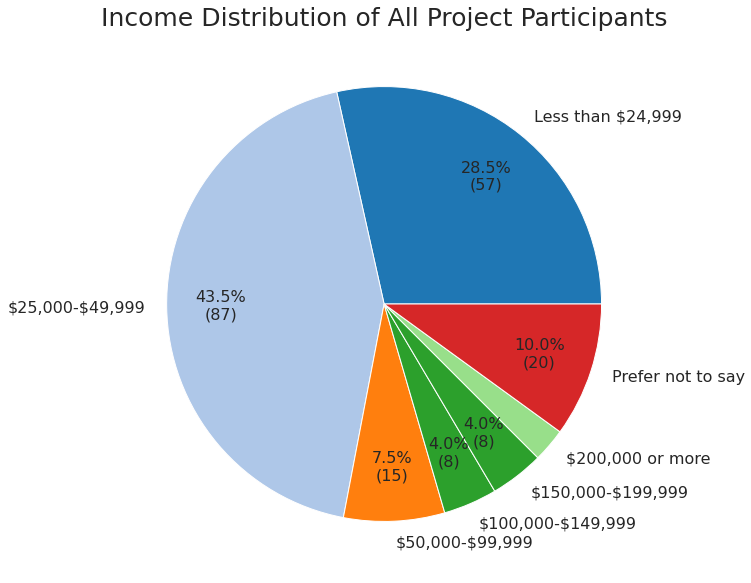

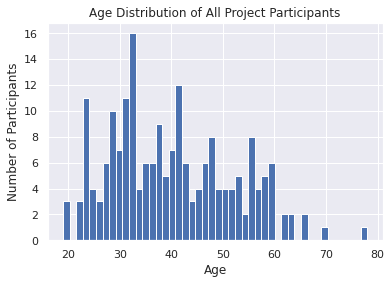

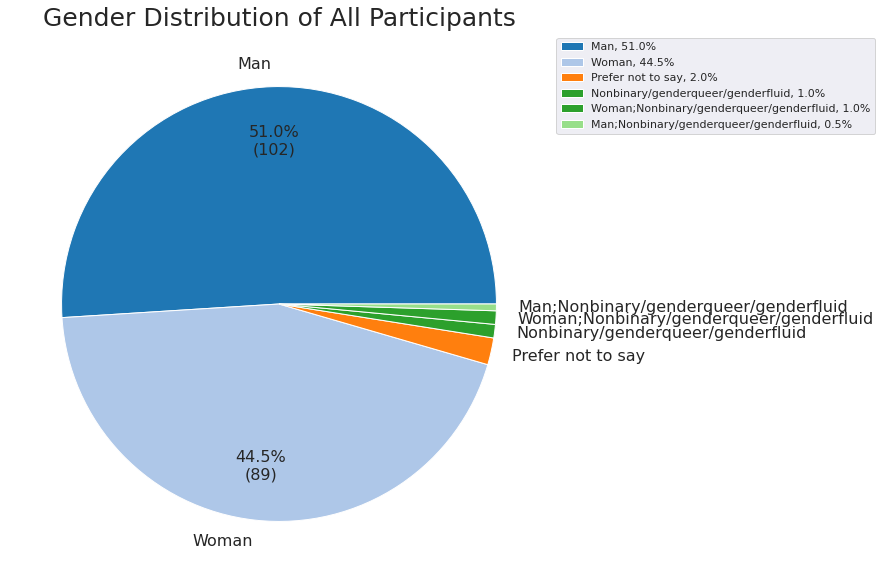

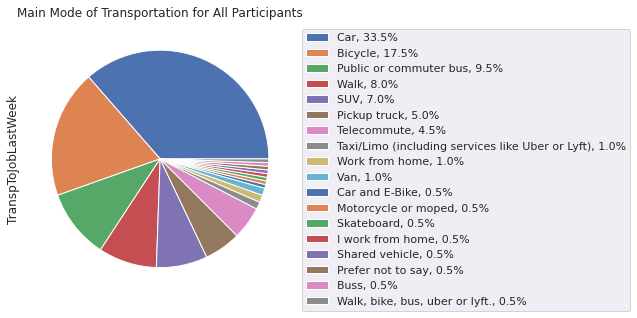

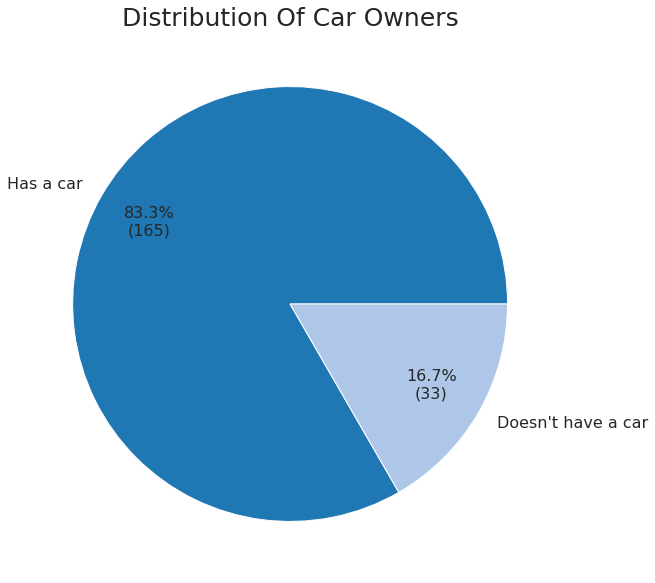

In [79]:
#Demographics of all project participants
returnIncomeDistribution(demogRecent,'Income Distribution of All Project Participants')
AgeDistribution(demogRecent,'Age Distribution of All Project Participants')
genderDistrb(demogRecent.Gender,'Gender Distribution of All Participants')
MainTransport(demogRecent.TranspToJobLastWeek,'Main Mode of Transportation for All Participants')
haveCar(demogRecent)

In [80]:
#maps user_email to user_id
import emission.core.get_database as edb 

#list(edb.get_uuid_db().find({}, {"user_email":1, "_id":0}))
list(edb.get_uuid_db().find({}, {"user_email":1, "uuid": 1, "_id":0}))
token = pd.DataFrame(list(edb.get_uuid_db().find({}, {"user_email":1, "uuid": 1, "_id":0})))
token = token.rename(columns={"uuid":"user_id"})
for i in range(len(token)):
    token.user_id.iloc[i] = str(token.user_id.iloc[i]).replace("-","")

token

,user_email,user_id
0,vail_7XujlKOYzJ2MmWh1,bd9cffc8dbf1402da479f9f148ec9e60
1,vail_4_BrvglmpUQk6dSv,fc8f71a38c82458dbf9718c3ee11a0f3
2,vail_14aC2LJ1c-gG_mGb,f446bf3102ff4bd99ea1c98f7d2f7af0
3,vail_Fu-HHHSegEum1AbC,8b1f3ba43de945bea79de6a81716ad04
4,vail_vJyqw9Bpjk4rynQ8,9606d6104d244960a77d9211c5b587ec
...,...,...
240,cc_wGj5RV6LZLAQKtVq,ac604b44fdca482fb753034cb55d1351
241,cc_lF-PA-72MqgVYkLL,73d60e747d194b81b7084ba44c0ff9aa
242,cc_kQyVhXg8jr5lYhma,92af52d111e04dc5a95a9dfdf0cc5dac
243,cc_YRPTw7MYhmu6rB6z,0d0ae3a556414d138c52a6040a203d24


In [81]:
df = demogRecent.merge(token,left_on=['user_id'],right_on=['user_id'],how='left')
df = df[df['user_email'].notnull()]
dfPar = df[df.user_email.str.startswith(('vail_','cc_','cc_ ','sc_','fc_','pc_','4c_'))]
dfPar = dfPar.reset_index()

participantDemog = dfPar
#participantDemog

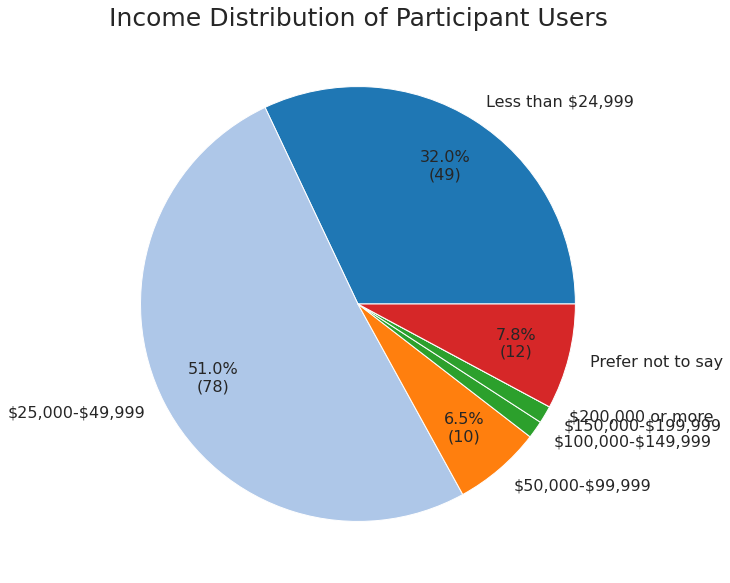

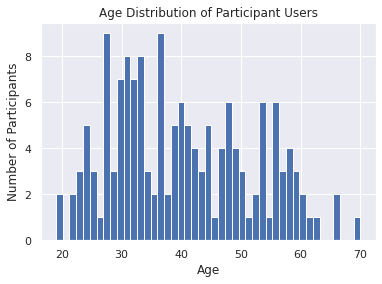

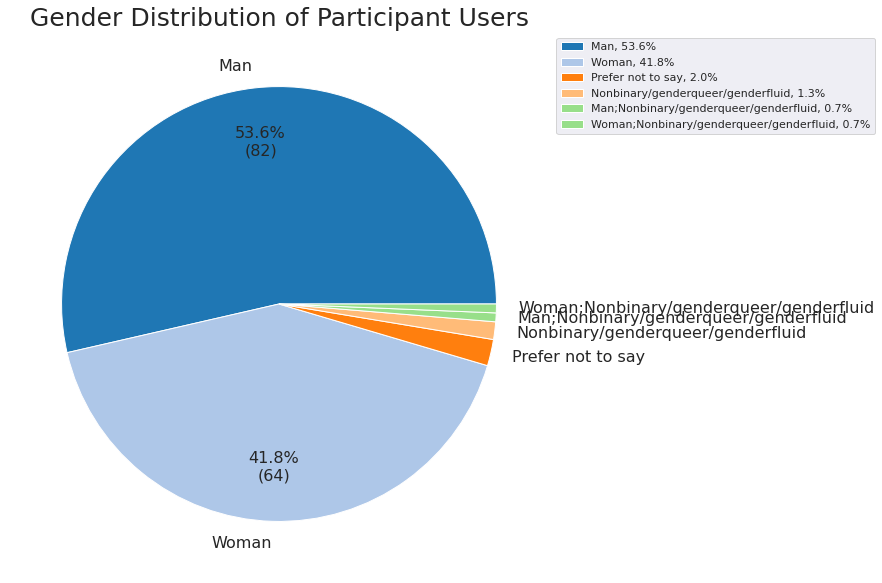

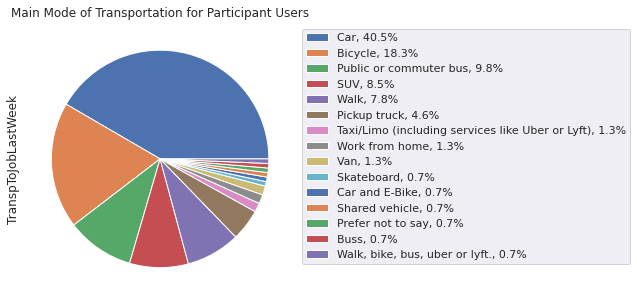

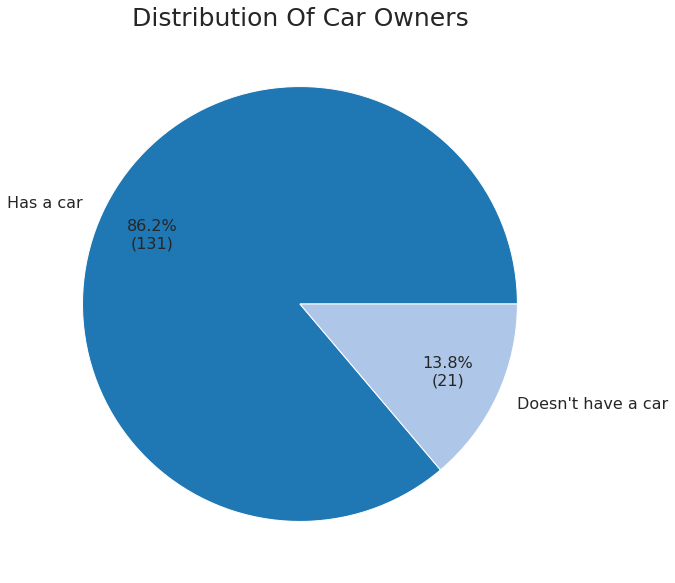

In [82]:
#Participant user demographics       
df = demogRecent.merge(token,left_on=['user_id'],right_on=['user_id'],how='left')
df = df[df['user_email'].notnull()]
dfPar = df[df.user_email.str.startswith(('vail_','cc_','cc_ ','sc_','fc_','pc_','4c_'))]
dfPar = dfPar.reset_index()

participantDemog = dfPar
participantDemog
returnIncomeDistribution(participantDemog,'Income Distribution of Participant Users')
AgeDistribution(participantDemog,'Age Distribution of Participant Users')
genderDistrb(participantDemog.Gender,'Gender Distribution of Participant Users')
MainTransport(participantDemog.TranspToJobLastWeek,'Main Mode of Transportation for Participant Users')
haveCar(participantDemog)

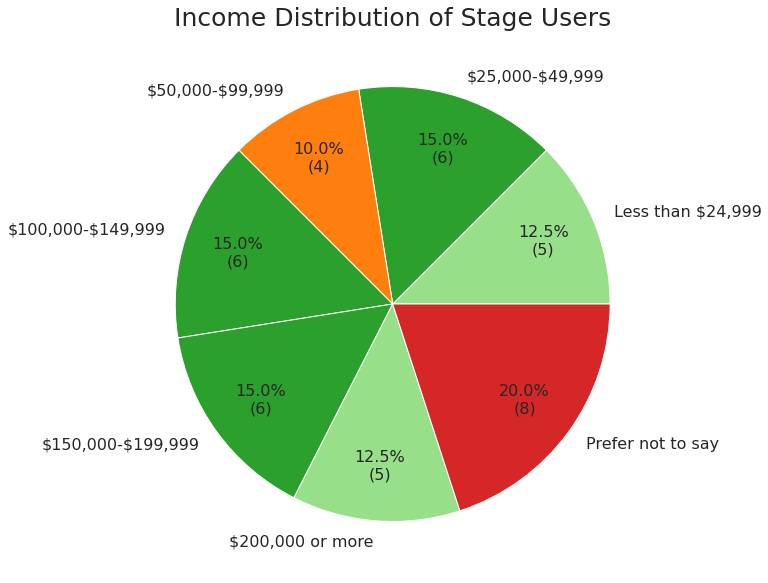

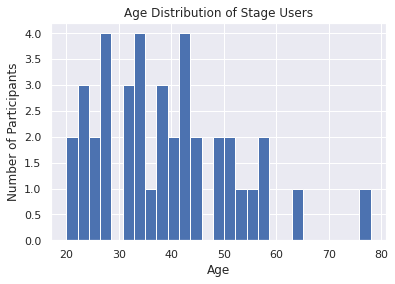

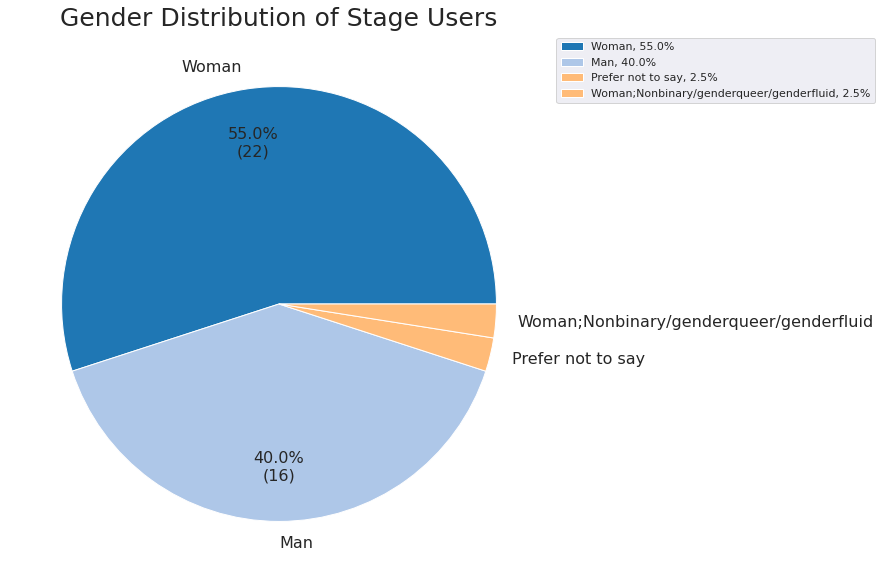

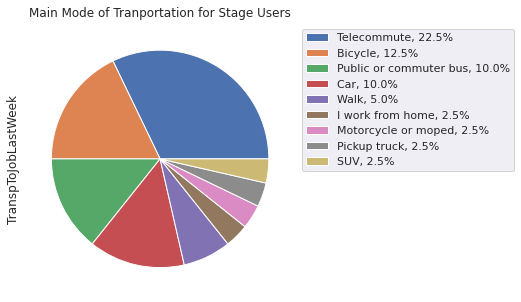

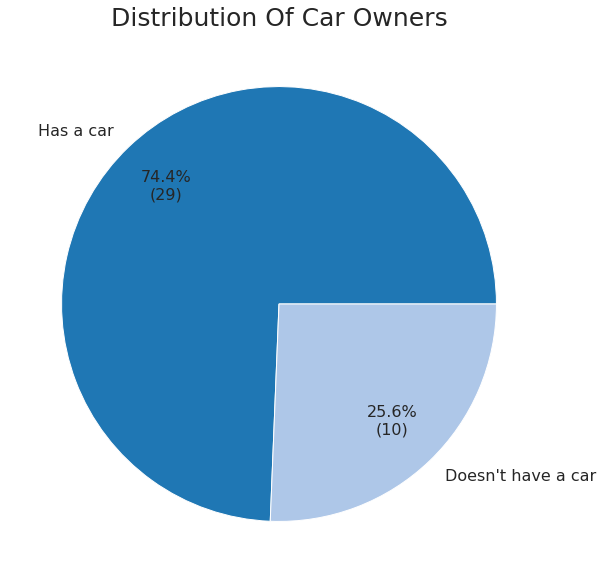

In [83]:
#Stage user demographics
df = demogRecent.merge(token,left_on=['user_id'],right_on=['user_id'],how='left')
df = df[df['user_email'].notnull()]
dfStage = df[df.user_email.str.startswith('stage')]
dfStage = dfStage.reset_index()
stageDemog = dfStage

returnIncomeDistribution(stageDemog,'Income Distribution of Stage Users')
AgeDistribution(stageDemog,'Age Distribution of Stage Users')
genderDistrb(stageDemog.Gender,'Gender Distribution of Stage Users')
MainTransport(stageDemog.TranspToJobLastWeek,'Main Mode of Tranportation for Stage Users')
haveCar(stageDemog)

In [84]:
#tells me if a uuid exists in a df (for testing purposes)
def exists(user_id, df):
    for i in range(len(df)):
        if df.iloc[i].user_id == user_id:
            print("True")

In [85]:
#NOT BEING USED
#Max's script
# takes list of user id's and returns the overlap in en_usr and es_usr
def usr_overlap(user_id):
    df_mode_users = demogRecent[demogRecent.iloc[:,1].isin(user_id)]
    return df_mode_users

# create df of all users from a certain program
def df_from_program(program):
    df = all_users.loc[all_users['user_email'].str.contains(program)]
    prog_users = df['uuid'].astype(str)
    prog_users = [i.replace('-','') for i in prog_users] # remove all dashes from strings
    return usr_overlap(prog_users)

all_users = pd.DataFrame(list(edb.get_uuid_db().find({}, {"user_email":1, "uuid": 1, "_id": 0})))
#stageDemog = df_from_program('stage_')

# create a df from all users except from the stage program
all_str_but_stage = 'cc_|sc_|vail_|fc_|pc_|4c_'
all_usr_but_stage = all_users.loc[all_users['user_email'].str.contains(all_str_but_stage)]

prog_users = all_usr_but_stage['uuid'].astype(str)
prog_users = [i.replace('-','') for i in prog_users] # remove all dashes from strings
#participantDemog = usr_overlap(prog_users)

def age_plots(df, title):
    ages = 2022- df['YearOfBirth']
    ages = ages[0 < ages < 140] # todo: maybe revisit this way of catching erroneous ages
    plt.hist(ages, bins = len(ages.unique()))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Age (years)')
    plt.xlim()
    plt.show()

#age_plots(demogRecent, 'All Users Demographic Age Distribution')

#age_plots(stageDemog, 'Stage Demographic Age Distribution')

#age_plots(participantDemog, 'Participant Demographic Age Distribution')

E-bike usage data

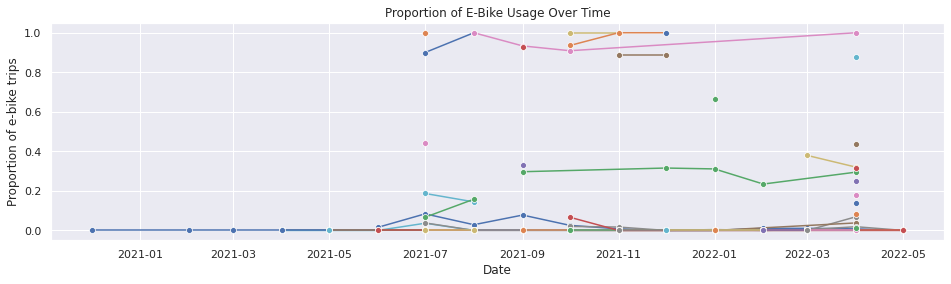

In [86]:
#returns every users proportion of ebike trips by month with proportion less than .1
df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')

def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2022']=percent
    #keeps rows whose max - min < .1
    for i in timeline.index:
        if timeline.loc[i].max() - timeline.loc[i].min() > .1:
            timeline.drop([i],inplace=True)
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.show

get_ebike_percent_byMonth(df)

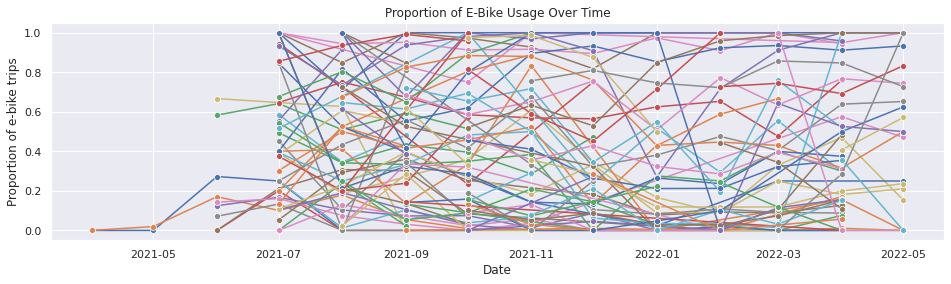

In [92]:
#returns every users proportion of ebike trips by month
#difference b/w max and min > .1, with max in 1st half, but not good visualization bc still hard to see
df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
import statistics
def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2022']=percent
    #keeps rows whose max - min < .1
    #return timeline.index
    #return timeline.loc['87cb88529b614c0e91ec07a33145659b'][0]==None
    #return statistics.mean(timeline.iloc[0]!=None)
    for i in timeline.index:
        #return timeline.loc[i][:int(len(timeline.loc[i])/2)]==0
        max = timeline.loc[i].max()
        #return statistics.mean(timeline.loc[i])
        if timeline.loc[i].max() - timeline.loc[i].min() < .1:
            timeline.drop([i],inplace=True)
        else:
            k = int(len(timeline.loc[i])/2)
            #print(i,':',k)
            #print(type(timeline.loc[i][k]))
            first=[]
            for j in range(k):
                #return timeline.loc[i][0]==None
                #return timeline.loc[i][j]==None
                if timeline.loc[i][j] == None:
                    if int(timeline.loc[i][j]) != max:
                        timeline.drop([i],inplace=True)
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.iloc[-1],y=timeline.iloc[i],data=timeline,marker='o')
        plt.show
        
    #for i in range(len(timeline1)-1):
     #   sns.lineplot(ax=ax,x=timeline1.loc[timeline1.index[-1]],y=timeline1.iloc[i],data=timeline,marker='o')
     #   plt.show

get_ebike_percent_byMonth(df)

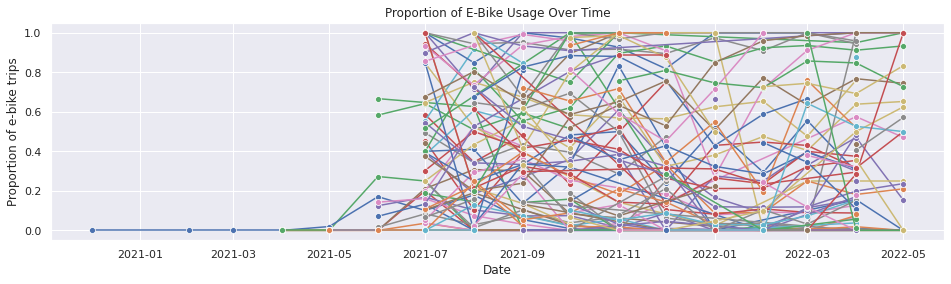

In [93]:
#returns every users proportion of ebike trips by month
#ALL PROJECT PARTCIPANTS
def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2022']=percent
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    #return user['month'+str(7)][2]
    #pd.set_option('display.max_rows', None)
    #return timeline
    #return timeline.iloc[1,0]
    #return countOfUsers
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.show

get_ebike_percent_byMonth(df)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


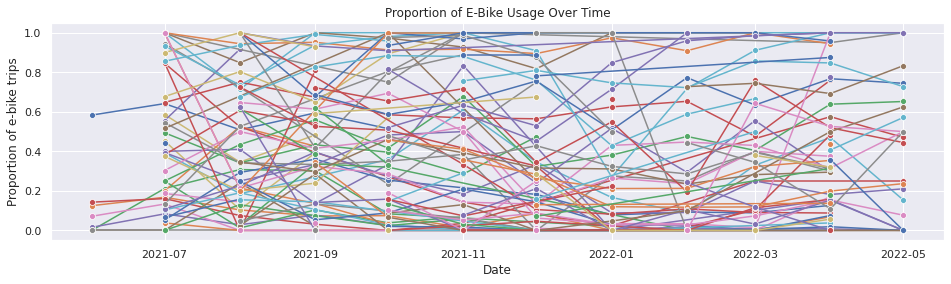

In [94]:
#returns every users proportion of ebike trips by month
#PARTICIPANT USERS ONLY

for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct

df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
#19-24,25-34,35-44,45-54,55+
df['Age_group']=''
for i in range(len(df)):
    if df.Age.iloc[i] >= 19 and df.Age.iloc[i] <= 24:
        df.at[i,'Age_group'] = '19-24'
    if df.Age.iloc[i] >= 25 and df.Age.iloc[i] <= 34:
        df.at[i,'Age_group'] = '25-34'
    if df.Age.iloc[i] >= 35 and df.Age.iloc[i] <= 44:
        df.at[i,'Age_group'] = '35-44'
    if df.Age.iloc[i] >= 45 and df.Age.iloc[i] <= 54:
        df.at[i,'Age_group'] = '45-54'
    if df.Age.iloc[i] >= 55:
        df.at[i,'Age_group'] = '55+'
demo = df[df['Timestamp'].notnull()]

def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].user_id.iloc[0]),'May 2022']=percent
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    #timeline["Age_group"]=demo.user_id.Age_group
    #return user['month'+str(7)][2]
    #pd.set_option('display.max_rows', None)
    #return timeline.iloc[0]
    #return timeline.iloc[1,0]
    #return countOfUsers
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.show

get_ebike_percent_byMonth(demo)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


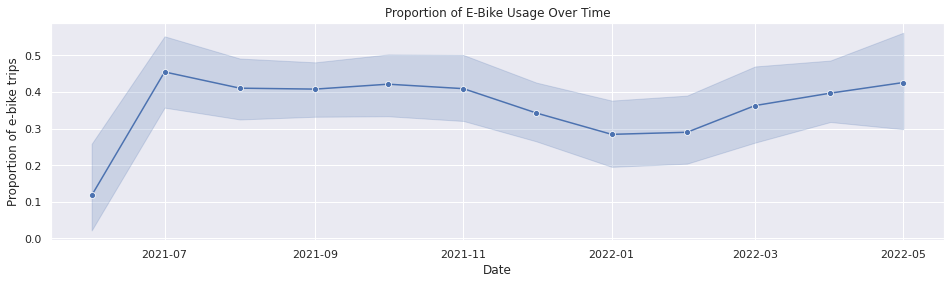

In [123]:
#returns the AVERAGE of proportion of ebike trips by month for all users

for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct

df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
#19-24,25-34,35-44,45-54,55+
df['Age_group']=''
for i in range(len(df)):
    if df.Age.iloc[i] >= 19 and df.Age.iloc[i] <= 24:
        df.at[i,'Age_group'] = '19-24'
    if df.Age.iloc[i] >= 25 and df.Age.iloc[i] <= 34:
        df.at[i,'Age_group'] = '25-34'
    if df.Age.iloc[i] >= 35 and df.Age.iloc[i] <= 44:
        df.at[i,'Age_group'] = '35-44'
    if df.Age.iloc[i] >= 45 and df.Age.iloc[i] <= 54:
        df.at[i,'Age_group'] = '45-54'
    if df.Age.iloc[i] >= 55:
        df.at[i,'Age_group'] = '55+'
demo = df[df['Timestamp'].notnull()]

def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'user_id':[],'Date':[],'percent':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            timeline=timeline.append({'user_id': user['month'+str(i)][j].user_id.iloc[0],'Date': pd.to_datetime(str(user['month'+str(i)][j].iloc[0].start_local_dt_year)+'-'+str(user['month'+str(i)][j].iloc[0].start_local_dt_month)),'percent':percent}, ignore_index=True)
                      #      
    #return timeline
    #return user['month'+str(7)][2]
    #pd.set_option('display.max_rows', None)
    #return timeline.loc[timeline.index[-1]]
    #return timeline[0:125].to_string(index=False,header=False)
    #return countOfUsers
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    #for i in range(len(timeline)-1):
    sns.lineplot(x=timeline.Date,y=timeline.percent,data=timeline,marker='o')
    plt.show

get_ebike_percent_byMonth(demo)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


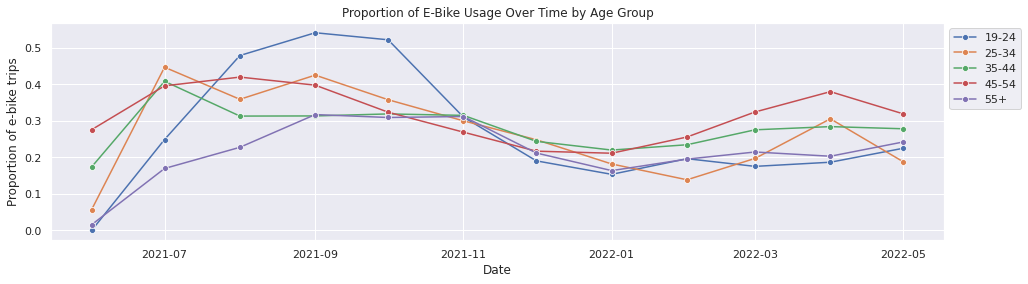

In [95]:
#returns every users proportion of ebike trips by month by age group
for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct

df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
#19-24,25-34,35-44,45-54,55+
df['Age_group']=''
for i in range(len(df)):
    if df.Age.iloc[i] >= 19 and df.Age.iloc[i] <= 24:
        df.at[i,'Age_group'] = '19-24'
    if df.Age.iloc[i] >= 25 and df.Age.iloc[i] <= 34:
        df.at[i,'Age_group'] = '25-34'
    if df.Age.iloc[i] >= 35 and df.Age.iloc[i] <= 44:
        df.at[i,'Age_group'] = '35-44'
    if df.Age.iloc[i] >= 45 and df.Age.iloc[i] <= 54:
        df.at[i,'Age_group'] = '45-54'
    if df.Age.iloc[i] >= 55:
        df.at[i,'Age_group'] = '55+'
demo = df[df['Timestamp'].notnull()]


def Monthly_ebike_propBy_AgeGroup(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfAgeGroups = trips.Age_group.value_counts().nunique()
    numOfGroups={}
    user={}
    for i in range(len(df)):
        numOfGroups['num'+str(i)]=df[i].Age_group.value_counts().nunique() #number of age groups in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('Age_group')] #f['u'+str(i)] is the month, the indexs are the age group      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfGroups['num'+str(i)]): #iterates through age groups per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Age_group.iloc[0]),'May 2022']=percent
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    #return user['month'+str(3)][0]
    #return timeline
    #return timeline.iloc[1,0]
    #timeline.sort_index()
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time by Age Group')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = timeline.index)
        plt.show

Monthly_ebike_propBy_AgeGroup(demo)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


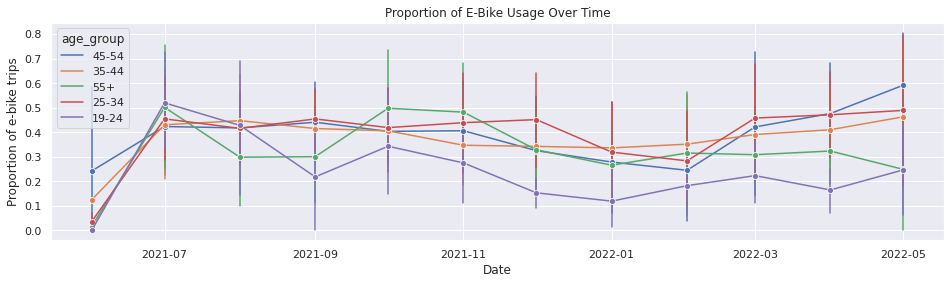

In [47]:
#returns every users proportion of ebike trips by month with error bars

for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct

df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
#19-24,25-34,35-44,45-54,55+
df['Age_group']=''
for i in range(len(df)):
    if df.Age.iloc[i] >= 19 and df.Age.iloc[i] <= 24:
        df.at[i,'Age_group'] = '19-24'
    if df.Age.iloc[i] >= 25 and df.Age.iloc[i] <= 34:
        df.at[i,'Age_group'] = '25-34'
    if df.Age.iloc[i] >= 35 and df.Age.iloc[i] <= 44:
        df.at[i,'Age_group'] = '35-44'
    if df.Age.iloc[i] >= 45 and df.Age.iloc[i] <= 54:
        df.at[i,'Age_group'] = '45-54'
    if df.Age.iloc[i] >= 55:
        df.at[i,'Age_group'] = '55+'
demo = df[df['Timestamp'].notnull()]

def get_ebike_percent_byMonth(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfUsers = trips.user_id.value_counts().nunique()
    numOfUsers={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfUsers['num'+str(i)]=df[i].user_id.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('user_id')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'user_id':[],'Date':[],'percent':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfUsers['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            timeline=timeline.append({'age_group': user['month'+str(i)][j].Age_group.iloc[0],'Date': pd.to_datetime(str(user['month'+str(i)][j].iloc[0].start_local_dt_year)+'-'+str(user['month'+str(i)][j].iloc[0].start_local_dt_month)),'percent':percent}, ignore_index=True)
                      #      
    #return timeline
    #return user['month'+str(7)][2]
    #pd.set_option('display.max_rows', None)
    #return timeline.loc[timeline.index[-1]]
    #return timeline[0:125].to_string(index=False,header=False)
    #return countOfUsers
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    #for i in range(len(timeline)-1):
    sns.lineplot(x=timeline.Date,y=timeline.percent,hue=timeline.age_group,err_style='bars',data=timeline,marker='o')
    plt.show

get_ebike_percent_byMonth(demo)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


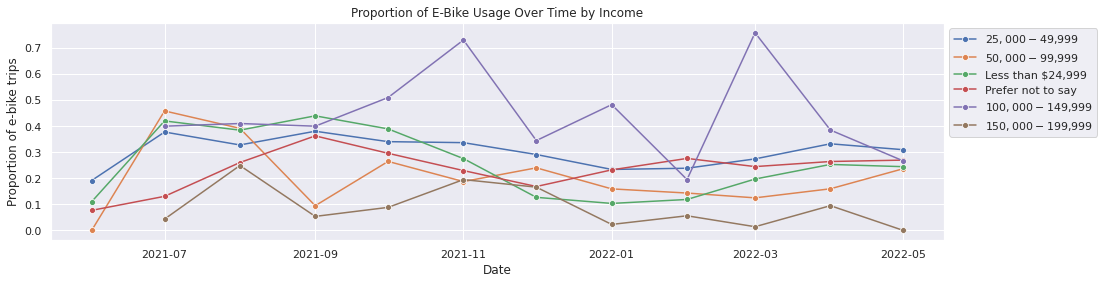

In [24]:
#returns every users proportion of ebike trips by month by income
for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct
df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
df = df[df['Timestamp'].notnull()]

def Monthly_ebike_propBy_Income(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfIncome = trips.Income.value_counts().nunique()
    numOfGroups={}
    user={}
    for i in range(len(df)):
        numOfGroups['num'+str(i)]=df[i].Income.value_counts().nunique() #number of age groups in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('Income')] #f['u'+str(i)] is the month, the indexs are the age group      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfGroups['num'+str(i)]): #iterates through age groups per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            else:
                percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].Income.iloc[0]),'May 2022']=percent
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    #return user['month'+str(3)][0]
    #return timeline
    #return timeline.iloc[1,0]
    #timeline.sort_index()
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time by Income')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = timeline.index)
        plt.show

Monthly_ebike_propBy_Income(df)

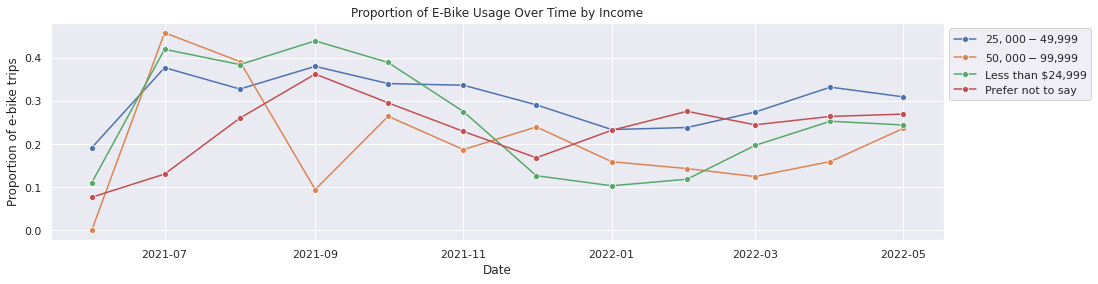

In [46]:
#Monthy ebike prop by income excluding higher income
demo1 = df
demo1=demo1.reset_index(drop=True)
demo1
#demo1.drop(demo1[demo1['Income'] == 'Prefer not to say'].index, inplace = True)
for i in range(0,len(demo1)-1):
    if demo1['Income'].loc[i].__contains__('100,000') or demo1['Income'].loc[i].__contains__('150,000') or demo1['Income'].loc[i].__contains__('200,000'):
        demo1.drop([i],inplace=True)
Monthly_ebike_propBy_Income(demo1)

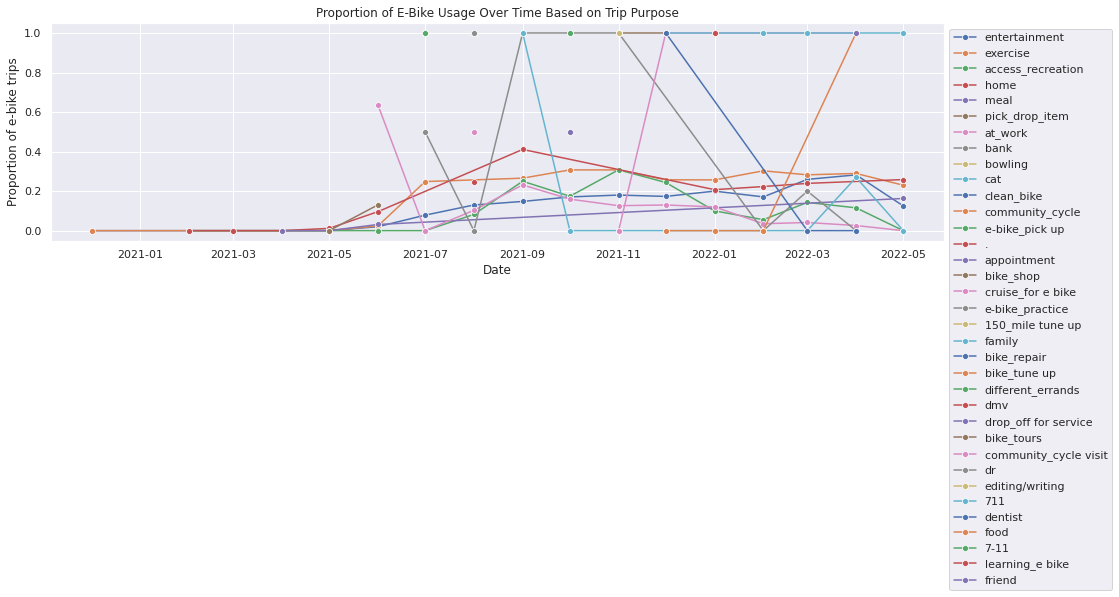

In [316]:
#returns trip purpose proportion of ebike trips by month excluding all NaN and 0 rows
import math
def ebike_month_purpose(trips):
    df = [rows for _, rows in trips.groupby(['start_local_dt_year','start_local_dt_month'])] #spilts dataframe into month-year
    count = trips.start_local_dt_month.value_counts().nunique() #count is the number of unique months in the dataset
    countOfPurposes = trips.purpose_confirm.value_counts().nunique()
    numOfPurposes={}
    user={}
    for i in range(len(df)):  #len(df) should be 17
        numOfPurposes['num'+str(i)]=df[i].purpose_confirm.value_counts().nunique() #number of unique users in each month
    for i in range(0, len(df)):
        user['month'+str(i)] = [rows for _, rows in df[i].groupby('purpose_confirm')] #f['u'+str(i)] is the month, the indexs are the user      
    timeline = pd.DataFrame({'December 2020':[],'January 2021':[],'February 2021':[],'March 2021':[],'April 2021':[],'May 2021':[],'June 2021':[],'July 2021':[],'August 2021':[],'September 2021':[],'October 2021':[],'November 2021':[],'December 2021':[],'January 2022':[],'February 2022':[],'March 2022':[],'April 2022':[],'May 2022':[]})
    for i in range(len(df)): #iterates through month  |   these for loops calculate percent of ebike usage per month
        for j in range(numOfPurposes['num'+str(i)]): #iterates through users per month
            #print(i,j)
            if user['month'+str(i)][j].mode_confirm.value_counts().__contains__('pilot_ebike'):
                ebike =user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            else:
                ebike = 0
            #ebike = user['month'+str(i)][j].mode_confirm.value_counts()['pilot_ebike']
            if sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True)) != 0:
                sumx = sum(user['month'+str(i)][j].mode_confirm.value_counts(dropna=True))
                percent = ebike/sumx
            #else:
            #    percent = 0
            #return percent
            #timeline = timeline.append()
            if user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2020:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'December 2020']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'January 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'February 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'March 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'April 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'May 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==6 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'June 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==7 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'July 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==8 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'August 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==9 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'September 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==10 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'October 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==11 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'November 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==12 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2021:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'December 2021']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==1 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'January 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==2 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'February 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==3 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'March 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==4 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'April 2022']=percent
            elif user['month'+str(i)][j].start_local_dt_month.iloc[0]==5 and user['month'+str(i)][j].start_local_dt_year.iloc[0]==2022:
                timeline.at[str(user['month'+str(i)][j].purpose_confirm.iloc[0]),'May 2022']=percent
    #return timeline
    #pd.set_option('display.max_rows', None)
    #timeline.drop([64]) 
    #timeline.drop([64], axis=0, inplace=True)
    #timeline.drop(['gas','move'],inplace=True)
    #return timeline.loc['entertainment'][0]==0
    #return timeline.loc['entertainment'][0]
    fig, ax = plt.subplots(figsize=(16,4))
    plt.title('Proportion of E-Bike Usage Over Time Based on Trip Purpose')
    plt.xlabel("Date")
    plt.ylabel("Proportion of e-bike trips")
    #timeline.reset_index(inplace=True)
  #  timeline1=timeline.drop([9])
    for i in timeline.index:
        count=0
        for j in range(17):
            if math.isnan(timeline.loc[i][j]) or timeline.loc[i][j]==0:
                count+=1
        if count == 17:
            timeline.drop([i],inplace=True)
    timeline.loc[len(timeline.index)]=[pd.to_datetime('2020-12'),pd.to_datetime('2021-01'),pd.to_datetime('2021-02'),pd.to_datetime('2021-03'),pd.to_datetime('2021-04'),pd.to_datetime('2021-05'),pd.to_datetime('2021-06'),pd.to_datetime('2021-07'),pd.to_datetime('2021-08'),pd.to_datetime('2021-09'),pd.to_datetime('2021-10'),pd.to_datetime('2021-11'),pd.to_datetime('2021-12'),pd.to_datetime('2022-01'),pd.to_datetime('2022-02'),pd.to_datetime('2022-03'),pd.to_datetime('2022-04'),pd.to_datetime('2022-05')]
    #return timeline
    #timeline=timeline.iloc[[0,1,3,5,7,8,15,16,21,65]]
    #return timeline
    for i in range(len(timeline)-1):
        sns.lineplot(ax=ax,x=timeline.loc[timeline.index[-1]],y=timeline.iloc[i],data=timeline,marker='o')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels = timeline.index)
        plt.show

ebike_month_purpose(df)

# Travel Patterns

In [21]:
for i in range(len(expanded_ct)):
    expanded_ct.user_id.iloc[i] = str(expanded_ct.user_id.iloc[i]).replace("-","")
#expanded_ct
df = expanded_ct.merge(participantDemog,left_on=['user_id'],right_on=['user_id'],how='left')
participant = df[df['Timestamp'].notnull()]

participant.drop(['Timestamp','user_id','YearOfBirth','Gender','DriversLicense','Student','HighestDegree','Work','MoreThanOneJob','FullPartTime','Job','TranspToJobLastWeek','DailyCommuteMinsToJob','ChangeStartTime','CanWFH','DaysPerWeekWFT','DescribesYouBest','OwnRentResidence','HomeType','Income','PplInHome','ChildrenUnder18','NumOfDrivers','NumVehicles','AltTranspt','MedCond','HowLongMedCond'],axis=1,inplace=True)
participant.drop(['level_0','index','user_email'],axis=1, inplace=True)
participant

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,start_place,end_place,cleaned_trip,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,user_input,start_local_dt_year,start_local_dt_month,start_local_dt_day,start_local_dt_hour,start_local_dt_minute,start_local_dt_second,start_local_dt_weekday,start_local_dt_timezone,end_local_dt_year,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode,Trip_purpose,Mode_confirm,Replaced_mode,distance_miles
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,61490c97298be5cdcb8ed75f,61490c97298be5cdcb8ed760,61490c97298be5cdcb8ed73d,[],61490ca0298be5cdcb8ed765,{'to_label': True},0.25,61490ca0298be5cdcb8ed769,"{'mode_confirm': 'drove_alone', 'purpose_confi...",2021,9,20,16,0,8,0,America/Denver,2021,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,1.632177e+09,drove_alone,personal_med,no_travel,Personal/Medical,"Car, drove alone",No Travel,9.390201
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,61490c97298be5cdcb8ed760,61491aa8b9593ff96f7257f8,61491aa7b9593ff96f7257d8,[],61491aafb9593ff96f725800,{'to_label': True},0.25,61491aafb9593ff96f725807,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,30,32,0,America/Denver,2021,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,1.632181e+09,drove_alone,shopping,drove_alone,Shopping,"Car, drove alone","Car, drove alone",0.131126
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,61491aa8b9593ff96f7257f8,61491aa8b9593ff96f7257f9,61491aa8b9593ff96f7257df,[],61491aafb9593ff96f725803,{'to_label': True},0.25,61491aafb9593ff96f725808,"{'purpose_confirm': 'shopping', 'mode_confirm'...",2021,9,20,16,56,13,0,America/Denver,2021,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,1.632181e+09,drove_alone,shopping,drove_alone,Shopping,"Car, drove alone","Car, drove alone",2.735949
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,61491aa8b9593ff96f7257f9,614928b7dd5719f85e04c59d,614928b7dd5719f85e04c57d,[],614928c0dd5719f85e04c5a2,{'to_label': True},0.25,614928c0dd5719f85e04c5a6,"{'mode_confirm': 'drove_alone', 'replaced_mode...",2021,9,20,17,19,25,0,America/Denver,2021,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,1.632185e+09,drove_alone,shopping,drove_alone,Shopping,"Car, drove alone","Car, drove alone",7.818875
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,6149df8862cecc2c7249b651,6149df8862cecc2c7249b652,6149df8862cecc2c7249b62b,[],6149df8862cecc2c7249b657,{'to_label': True},0.25,6149df8862cecc2c7249b65b,"{'mode_confirm': 'shared_ride', 'purpose_confi...",2021,9,21,6,59,10,1,America/Denver,2021,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,1.632231e+09,shared_ride,work,bike,Work,"Car, with others",Regular Bike,1.277

,vals,pct
Pilot ebike,14207,28.728868
"Car, drove alone",12184,24.638033
"Car, with others",11332,22.915150
Walk,6822,13.795195
Not a Trip,2160,4.367872
...,...,...
Bikeshare,51,0.103130
Train,36,0.072798
Free Shuttle,36,0.072798
Skate board,29,0.058643


,vals,pct
Pilot ebike,14207,28.728868
"Car, drove alone",12184,24.638033
"Car, with others",11332,22.915150
Walk,6822,13.795195
Not a Trip,2160,4.367872
Bus,1035,2.092939


,vals,pct
Pilot ebike,14207.0,28.728868
"Car, drove alone",12184.0,24.638033
"Car, with others",11332.0,22.915150
Walk,6822.0,13.795195
Not a Trip,2160.0,4.367872
Bus,1035.0,2.092939
Other,1712.0,3.461943


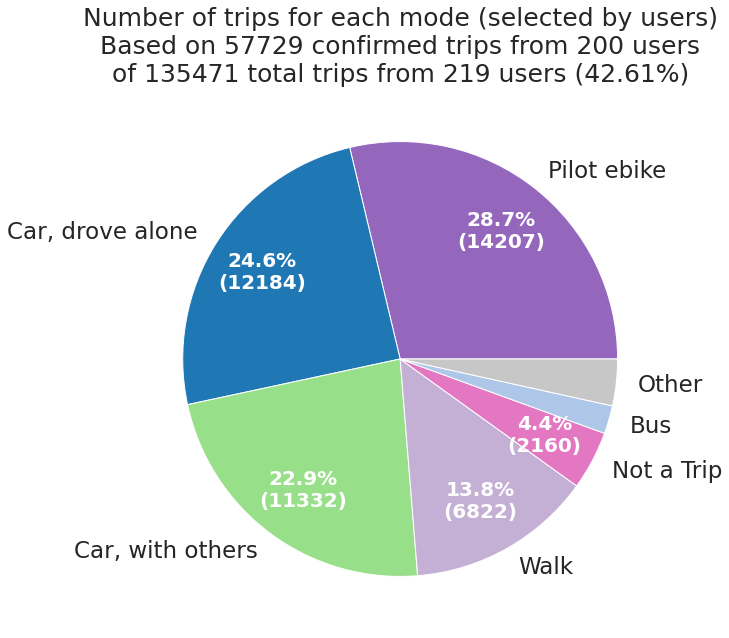

Pilot ebike         14207
Car, drove alone    12184
Car, with others    11332
Walk                 6822
Not a Trip           2160
                    ...  
Bikeshare              51
Train                  36
Free Shuttle           36
Skate board            29
Scooter share           7
Name: Mode_confirm, Length: 14, dtype: int64


In [22]:
#Mode share for PARTICIPANT USERS ONLY
labels_mc = participant['Mode_confirm'].value_counts(dropna=True).keys().tolist()
values_mc = participant['Mode_confirm'].value_counts(dropna=True).tolist()
plot_title= "Number of trips for each mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_mc,values_mc,file_name)
print(participant['Mode_confirm'].value_counts(dropna=True))

,vals,pct
Pilot ebike,4840,45.107176
"Car, drove alone",2865,26.700839
Walk,1318,12.283318
"Car, with others",1013,9.440820
Bus,241,2.246039
...,...,...
Other,114,1.062442
Taxi/Uber/Lyft,32,0.298229
Bikeshare,22,0.205033
Scooter share,2,0.018639


,vals,pct
Pilot ebike,4840,45.107176
"Car, drove alone",2865,26.700839
Walk,1318,12.283318
"Car, with others",1013,9.440820
Bus,241,2.246039


,vals,pct
Pilot ebike,4840.0,45.107176
"Car, drove alone",2865.0,26.700839
Walk,1318.0,12.283318
"Car, with others",1013.0,9.440820
Bus,241.0,2.246039
Other,453.0,4.221808


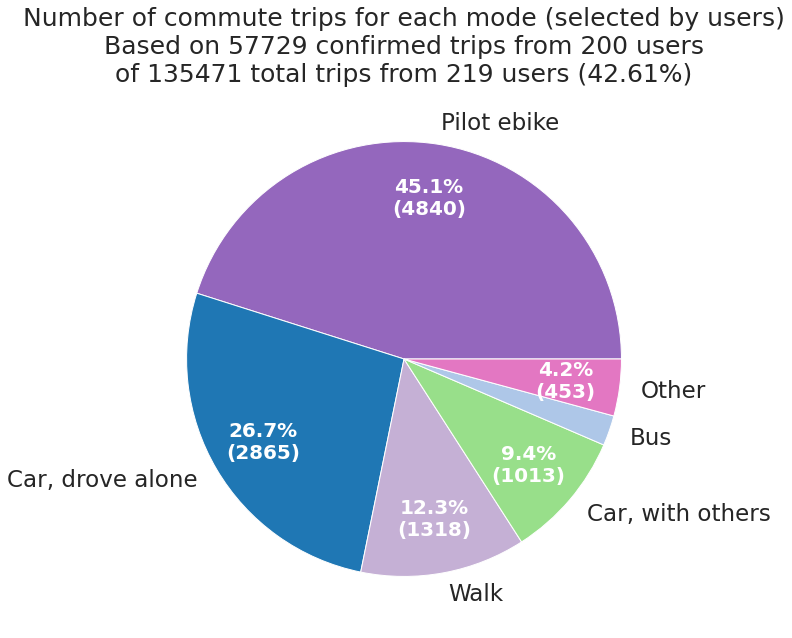

Pilot ebike         4840
Car, drove alone    2865
Walk                1318
Car, with others    1013
Bus                  241
                    ... 
Other                114
Taxi/Uber/Lyft        32
Bikeshare             22
Scooter share          2
Free Shuttle           1
Name: Mode_confirm, Length: 12, dtype: int64


In [23]:
labels_mc = participant.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True).keys().tolist()
values_mc = participant.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True).tolist()
plot_title= "Number of commute trips for each mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_commute_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_mc,values_mc,file_name)
print(participant.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True))

In [27]:
participant.loc[participant['Replaced_mode'] == 'Pilot ebike'].Mode_confirm.unique()

array(['Walk', 'Car, with others', 'Bus', 'Not a Trip',
       'Car, drove alone'], dtype=object)

,vals,pct
Pilot ebike,13556,30.835722
"Car, drove alone",10472,23.820572
"Car, with others",8908,20.262954
Walk,6777,15.415586
Not a Trip,1951,4.437924
...,...,...
Bikeshare,49,0.111460
Free Shuttle,32,0.072790
Skate board,28,0.063691
Train,16,0.036395


,vals,pct
Pilot ebike,13556,30.835722
"Car, drove alone",10472,23.820572
"Car, with others",8908,20.262954
Walk,6777,15.415586
Not a Trip,1951,4.437924


,vals,pct
Pilot ebike,13556.0,30.835722
"Car, drove alone",10472.0,23.820572
"Car, with others",8908.0,20.262954
Walk,6777.0,15.415586
Not a Trip,1951.0,4.437924
Other,2298.0,5.227242


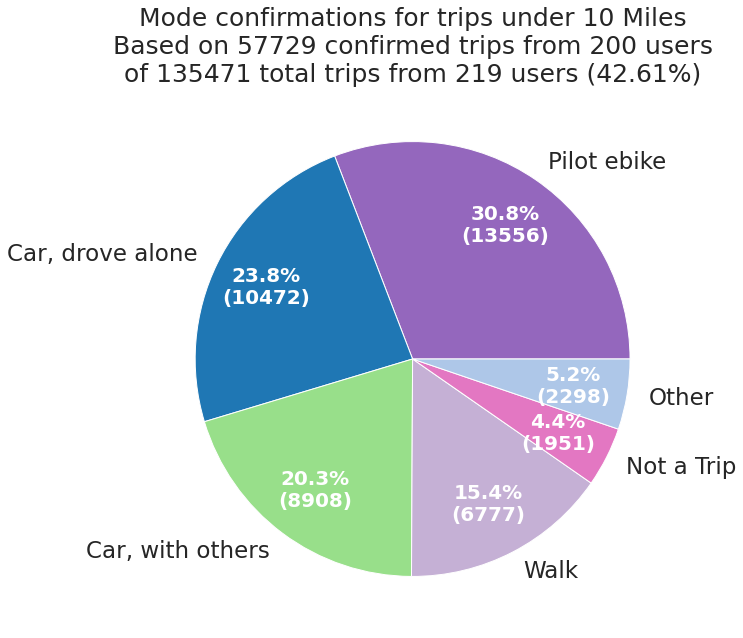

Pilot ebike         13556
Car, drove alone    10472
Car, with others     8908
Walk                 6777
Not a Trip           1951
                    ...  
Bikeshare              49
Free Shuttle           32
Skate board            28
Train                  16
Scooter share           7
Name: Mode_confirm, Length: 14, dtype: int64


In [25]:
labels_d10 = participant.loc[(participant['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True).keys().tolist()
values_d10 = participant.loc[(participant['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True).tolist()
plot_title="Mode confirmations for trips under 10 Miles\n%s" % quality_text
file_name ='ntrips_under10miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_d10,values_d10,file_name)
print(participant.loc[(participant['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True))

,vals,pct
"Car, with others",116539.304121,36.087760
"Car, drove alone",70665.219392,21.882313
Other,61812.543094,19.140978
Pilot ebike,42399.994459,13.129655
Not a Trip,9828.526917,3.043518
...,...,...
Train,753.359052,0.233286
Bikeshare,156.139327,0.048350
Free Shuttle,126.684561,0.039229
Skate board,115.050974,0.035627


,vals,pct
"Car, with others",116539.304121,36.087760
"Car, drove alone",70665.219392,21.882313
Other,61812.543094,19.140978
Pilot ebike,42399.994459,13.129655
Not a Trip,9828.526917,3.043518
Walk,9346.293344,2.894189
Bus,8125.459736,2.516144


,vals,pct
"Car, with others",116539.304121,36.087760
"Car, drove alone",70665.219392,21.882313
Other,66028.248101,20.446420
Pilot ebike,42399.994459,13.129655
Not a Trip,9828.526917,3.043518
Walk,9346.293344,2.894189
Bus,8125.459736,2.516144


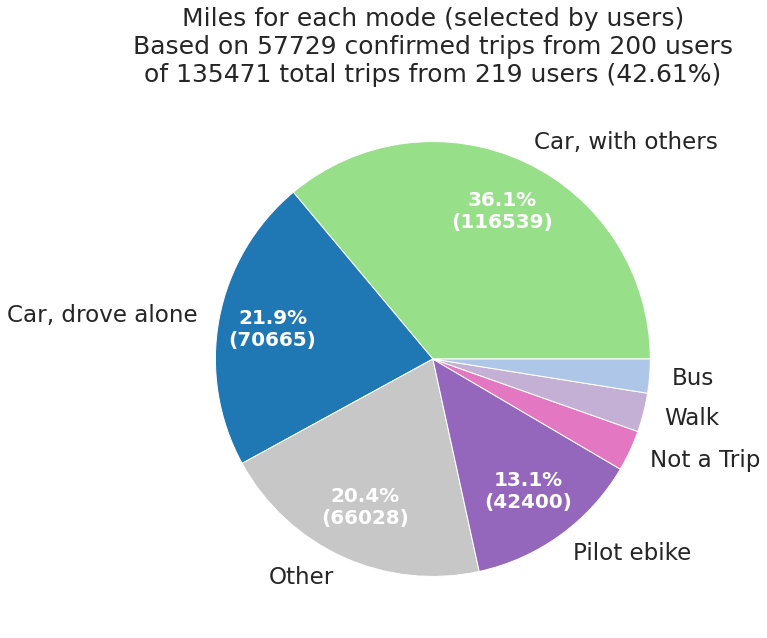

        Mode_confirm  Total (miles)  Count  Average (miles)
3   Car, with others  116539.304121  11332        10.284090
2   Car, drove alone   70665.219392  12184         5.799837
6              Other   61812.543094    843        73.324488
7        Pilot ebike   42399.994459  14207         2.984444
5         Not a Trip    9828.526917   2160         4.550244
..               ...            ...    ...              ...
12             Train     753.359052     36        20.926640
0          Bikeshare     156.139327     51         3.061555
4       Free Shuttle     126.684561     36         3.519016
10       Skate board     115.050974     29         3.967275
9      Scooter share      12.621231      7         1.803033

[14 rows x 4 columns]


In [26]:
miles = participant.groupby('Mode_confirm').agg({'distance_miles': ['sum', 'count' , 'mean']})
miles.columns = ['Total (miles)', 'Count', 'Average (miles)']
miles = miles.reset_index()
miles =miles.sort_values(by=['Total (miles)'], ascending=False)

#data
miles_dict = dict(zip(miles['Mode_confirm'], miles['Total (miles)']))

labels_m = []
values_m = []

for x, y in miles_dict.items():
    labels_m.append(x)
    values_m.append(y)

plot_title="Miles for each mode (selected by users)\n%s" % quality_text
file_name ='miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_m,values_m,file_name)
print(miles)

Energy Analysis

In [46]:
# Loading mapping dictionaries from mapping_dictionaries notebook

%store -r df_EI
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_re = defaultdict(lambda: 'Other',dic_re)

In [47]:
participant['Mode_confirm_fuel']= participant['Mode_confirm'].map(dic_fuel)
participant['Replaced_mode_fuel']= participant['Replaced_mode'].map(dic_fuel)

In [48]:
participant = scaffolding.energy_intensity(expanded_ct, df_EI, 'distance','Replaced_mode', 'Mode_confirm')
participant = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles','Replaced_mode', 'Mode_confirm')

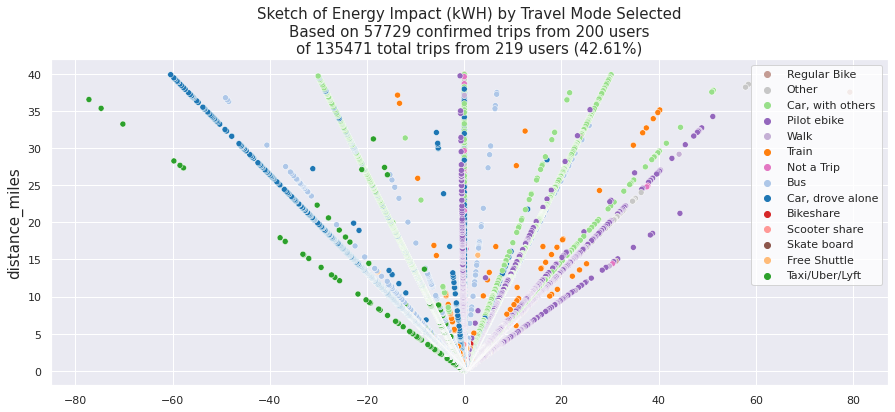

In [49]:
data=participant.loc[(participant['distance_miles'] <= 40)].sort_values(by=['Energy_Impact(kWH)'], ascending=False)   
x='Energy_Impact(kWH)'
y='distance_miles'
legend ='Mode_confirm'
plot_title="Sketch of Energy Impact (kWH) by Travel Mode Selected\n%s" % quality_text
file_name ='sketch_distance_energy_impact%s.png' % file_suffix
distancevsenergy(data,x,y,legend,plot_title,file_name)

In [50]:
#eirp : energy impact replaced_mode
eirc=participant.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
eirc.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
eirc = eirc.reset_index()
eirc = eirc.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
eirc['boolean'] = eirc['Sketch of Total Energy_Impact(kWH)'] > 0

#eimc : energy impact mode_confirm
eimc=participant.groupby('Mode_confirm').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
eimc.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
eimc = eimc.reset_index()
eimc = eimc.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)


subset1 = eirc [['Replaced_mode', 'Sketch of Total Energy_Impact(kWH)']].copy()
subset1.rename(columns = {'Replaced_mode':'Transport Mode','Sketch of Total Energy_Impact(kWH)':'Replaced_Mode' }, inplace=True)

subset2 = eimc [['Mode_confirm', 'Sketch of Total Energy_Impact(kWH)']].copy()
subset2.rename(columns = {'Mode_confirm':'Transport Mode','Sketch of Total Energy_Impact(kWH)':'Mode_Confirm' }, inplace=True)

df_plot = pd.merge(subset1, subset2, on="Transport Mode")
df = pd.melt(df_plot , id_vars=['Transport Mode'], value_vars=['Replaced_Mode','Mode_Confirm'], var_name='selection')
df.rename(columns = {'value':'Energy Impact (kWH)'}, inplace = True)

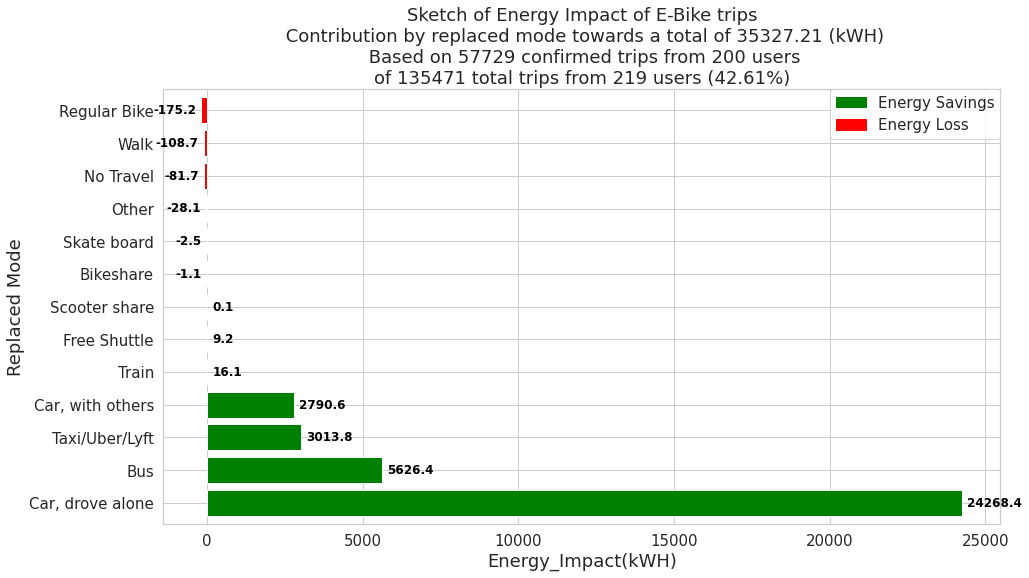

In [51]:
#Sketch of Energy Impact by E-Bike Trips
data_eb = participant.query("Mode_confirm == 'Pilot ebike'")
# ebei : ebike energy impact
ebei=data_eb.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
ebei.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
ebei= ebei.reset_index()
ebei = ebei.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
ebei['boolean'] = ebei['Sketch of Total Energy_Impact(kWH)'] > 0
net_energy_saved = round(sum(ebei['Sketch of Total Energy_Impact(kWH)']), 2)

x = ebei['Sketch of Total Energy_Impact(kWH)']
y = ebei['Replaced_mode']
color =ebei['boolean']

plot_title="Sketch of Energy Impact of E-Bike trips\n Contribution by replaced mode towards a total of %s (kWH)\n %s" % (net_energy_saved, quality_text)
file_name ='sketch_energy_impact_ebike%s.png' % file_suffix
energy_impact(x,y,color,plot_title,file_name)

In [53]:
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct,'distance_miles','Replaced_mode', 'Mode_confirm')

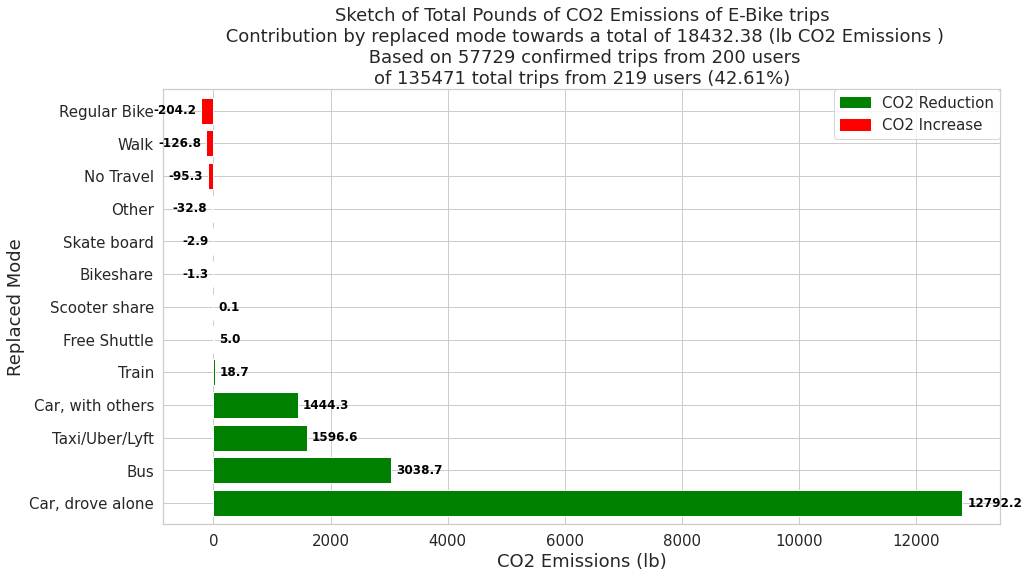

In [54]:
data_eb = participant.query("Mode_confirm == 'Pilot ebike'")

ebco2=data_eb.groupby('Replaced_mode').agg({'CO2_Impact(lb)': ['sum', 'mean']},)
ebco2.columns = ['total_lb_CO2_emissions', 'average_lb_CO2_emission']
ebco2 = ebco2.reset_index()
ebco2 = ebco2.sort_values(by=['total_lb_CO2_emissions'], ascending=False)
ebco2['boolean'] = ebco2['total_lb_CO2_emissions'] > 0
net_CO2_emissions = round(sum(ebco2['total_lb_CO2_emissions']), 2)

x = ebco2['total_lb_CO2_emissions']
y = ebco2['Replaced_mode']
color = ebco2['boolean']

plot_title="Sketch of Total Pounds of CO2 Emissions of E-Bike trips\n Contribution by replaced mode towards a total of %s (lb CO2 Emissions )\n %s" % (net_CO2_emissions, quality_text)
file_name ='sketch_CO2impact_ebike%s.png' % file_suffix
CO2_impact(x,y,color,plot_title,file_name)